**MVP** Machine Learning & Analytics

Nome: Mateus Sales Bentes

Matr√≠cula: 4052025000569

Dataset: [alpindale/two-million-bluesky-posts](https://huggingface.co/datasets/alpindale/two-million-bluesky-posts)

# Descri√ß√£o do Problema

O conjunto de dados `alpindale/two-million-bluesky-posts` cont√©m 2 milh√µes de postagens p√∫blicas coletadas da API firehose da Bluesky Social, destinadas √† pesquisa de aprendizado de m√°quina e experimenta√ß√£o com dados de m√≠dia social. O objetivo principal √© classificar as posnatgens em 5 t√≥picos: Links/TinyURL, Espanhol/Isadora Duncan, Reflex√µes/Trabalho, Twitter/Blog Pessoal, Dia a Dia/Sentimentos.

Hip√≥teses do Problema

As hip√≥teses que tracei s√£o as seguintes:

    As diferentes postagens do Blysky podem ser distinguidas com base nos problemas das modelagens dos t√≥picos?

    Os tipos de post influenciam negativamente o desempenho da modelagem de t√≥picos (NMF), por exemplo, gerando t√≥picos vazios, redundantes ou mal definidos?

    As postagens sobre Twitter ou Blog Pessoal s√£o mais comuns?


##Tipo de Problema

Este √© um problema de classifica√ß√£o n√£o supervisionada (tamb√©m conhecido como clustering). Dado um conjunto de posts textuais do Bluesky, o objetivo √© agrupar automaticamente os textos em t√≥picos latentes, com base em suas similaridades sem√¢nticas, sem utilizar r√≥tulos previamente definidos.

## Sele√ß√£o de Dados

O dataset `alpindale/two-million-bluesky-posts` √© um conjunto de dados p√∫blico contendo mais de 2 milh√µes de postagens da rede social Bluesky, coletadas ao longo de 2024. Cada entrada representa um post textual feito por um usu√°rio, contendo campos como o conte√∫do da postagem, data, autor, e outros metadados.

Para esta an√°lise, foi selecionada uma amostra textual dos posts, extra√≠da do campo principal de conte√∫do (text). A sele√ß√£o foi feita de forma aleat√≥ria ou por recorte manual, com o objetivo de testar a viabilidade da modelagem de t√≥picos em um subconjunto representativo.

Essa escolha permite avaliar o comportamento do modelo em posts reais da plataforma, que apresentam caracter√≠sticas como:

    textos curtos,

    informalidade e varia√ß√£o de linguagem,

    presen√ßa frequente de links, emojis, hashtags ou siglas.

Tais caracter√≠sticas desafiam m√©todos tradicionais de an√°lise de t√≥picos, o que torna o dataset uma base √∫til tanto para experimentos de pr√©-processamento quanto para diagn√≥sticos de qualidade de agrupamento.

## Atributos do Dataset

O dataset `alpindale/two-million-bluesky-posts` cont√©m aproximadamente 2 milh√µes de postagens da rede social Bluesky. Cada entrada representa um post e possui sete atributos principais:

- ***uri*** (Identificador √∫nico do post na Bluesky.)
- ***cid*** (Content ID, usado para versionamento e verifica√ß√£o de integridade.)
- ***text*** (Conte√∫do textual da postagem. Esse √© o principal campo usado na an√°lise.)
- ***langs*** (Lista de idiomas detectados no post (ex: ["en"]).)
- ***tags*** (Hashtags presentes na postagem.)
- ***indexed_at*** (Data e hora em que o post foi indexado.)
- ***author*** (Informa√ß√µes sobre o autor do post (detalhado abaixo).)


# Importa√ß√£o das Bibliotecas Necess√°rias e Carga de Dados

Esta se√ß√£o consolida todas as bibliotecas essenciais utilizadas nas etapas de pr√©-processamento, an√°lise, modelagem de t√≥picos e visualiza√ß√£o dos dados, al√©m de realizar o carregamento inicial do dataset `alpindale/two-million-bluesky-posts`, dispon√≠vel na plataforma Hugging Face.

In [1]:
# Instalar/atualizar a biblioteca `datasets`, necess√°ria para carregar dados do Hugging Face
!pip install --upgrade datasets

In [2]:
## Importa√ß√£o de Bibliotecas

# --- Utilit√°rios e Sistema ---
import os
import re
import pickle
import warnings
from tqdm import tqdm

# --- Manipula√ß√£o de Dados ---
import numpy as np
import pandas as pd

# --- Visualiza√ß√£o ---
import matplotlib.pyplot as plt

# --- Aprendizado de M√°quina ---
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# --- Datasets Externos ---
from datasets import load_dataset

# Suprimir avisos do scikit-learn
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
## Carga do Dataset (Streaming via JSONL)

# Ignorar aviso sobre token HF (caso apare√ßa)
warnings.filterwarnings("ignore", message="The secret `HF_TOKEN` does not exist")

data_files = [
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_075630.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_082640.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_085625.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_092509.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_095318.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_102059.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_104826.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_111413.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_113858.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_120237.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_122447.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_124559.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_130559.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_132451.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_134301.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_140039.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_141754.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_143458.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_145146.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_150757.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_152348.jsonl",
]

# Carregar o dataset em modo streaming
print("Carregando dataset do Bluesky...")
#ds = load_dataset("alpindale/two-million-bluesky-posts") # Ou talvez com streaming=True ou outros par√¢metros
ds = load_dataset(
    "json",
    data_files=data_files,
    streaming=True
)


# Obter as 5 primeiras linhas
print("\nAs 5 primeiras linhas do dataset:")
primeiras_linhas = list(ds['train'].take(5))

# Exibir as 5 primeiras linhas de forma organizada
for i, exemplo in enumerate(primeiras_linhas):
    print(f"\nPost {i+1}:")
    for chave, valor in exemplo.items():
        # Formata√ß√£o mais limpa para melhor visualiza√ß√£o
        if chave == 'text':
            print(f"  Texto: {valor}")
        elif chave == 'author':
            print(f"  Autor: {valor}")
        elif chave == 'created_at':
            print(f"  Data: {valor}")
        elif chave == 'has_images':
            print(f"  Cont√©m imagens: {valor}")
        elif chave == 'reply_to' and valor is not None:
            print(f"  Resposta a: {valor}")

# Converter para DataFrame do pandas (opcional)
df = pd.DataFrame(primeiras_linhas)
print("\nDados como DataFrame do pandas:")
print(df)

Carregando dataset do Bluesky...


Resolving data files:   0%|          | 0/21 [00:00<?, ?it/s]


As 5 primeiras linhas do dataset:

Post 1:
  Texto: Í∏∞ÏÇ¨Î°úÏÑúÏùò Ïã§Î†•ÏùÄ ÌÉÄÏùò Ï∂îÏ¢ÖÏùÑ Î∂àÌóàÌïòÏßÄÎßå ÏùºÏÉÅÏÉùÌôúÌÜ†ÌÅ¨Îäî ÏòÅ Ïñ¥ÏÉâÌïú Îë†Ï™ºÎ°±Í≥º Ï†ÅÎãπÌûà Ï≥êÎÇ¥Ï£ºÎäî Îë†ÎÑ§ÏÇ¨
  Data: 2024-11-27T07:56:28.535Z
  Autor: did:plc:z3dbv7bbotsaxzdmmlwoypha
  Cont√©m imagens: False

Post 2:
  Texto: Lovely stuff.
  Data: 2024-11-27T07:56:28.717Z
  Autor: did:plc:4dn3nlaku6z3ltxzkxglyqdq
  Cont√©m imagens: False
  Resposta a: at://did:plc:y7vhfdg5iq7qbotunr767enp/app.bsky.feed.post/3lbtrogbmd22o

Post 3:
  Texto: ÎààÏù¥ ÏôÄÎ∞© ÎÇ¥Î†§ÏÑú Î¨¥Í±∞ÏõåÏßÑ ÎÇòÎ¨¥Ïóê ÌñáÎπõÏù¥ Ï®çÌïòÍ≤å ÎìúÎãàÍπå ÏòàÏÅòÎã§
  Data: 2024-11-27T07:56:21.343Z
  Autor: did:plc:fn4xjeryjchlrtjwippuumxm
  Cont√©m imagens: True

Post 4:
  Texto: ÁØÑ„ÅÆÂ≠ó„Åå‰ΩøÁî®„Åï„Çå„Å¶„ÅÑ„Çã„ÅÇ„Åü„Çä3Á¥ö‰ª•‰∏ä„Å™„Çì„Å†„Çç„ÅÜ„Åë„Å©„ÄÅÊôÇ‰∫ã„ÇíÊâ±„Å£„ÅüÂïèÈ°å„ÇÇÂá∫„Åô„Çì„Å†„Å≠„ÄÇ
  Data: 2024-11-27T07:56:28.499Z
  Autor: did:plc:aaf7jrpncnzlbiqfzkgugowq
  Cont√©m imagens: False

Post 5:
  Texto: WoAH
  Data: 2024-11-27T07:

# An√°lise de Dados

Nesta etapa de An√°lise Explorat√≥ria de Dados (EDA) sobre o dataset `alpindale/two-million-bluesky-posts`, visamos:

- Explorar as caracter√≠sticas b√°sicas do dataset, como a distribui√ß√£o de idiomas, presen√ßa de hashtags, e frequ√™ncia dos autores.
- Entender o conte√∫do dos textos para identificar padr√µes iniciais, temas e poss√≠veis ru√≠dos.
- Visualizar a distribui√ß√£o dos posts por t√≥picos e tipos de conte√∫do, utilizando t√©cnicas como gr√°ficos de barras e nuvens de palavras.
- Avaliar a qualidade dos dados para poss√≠veis limpezas futuras, como remo√ß√£o de posts muito curtos, links irrelevantes, ou ru√≠do textual.
- Preparar o dataset para as pr√≥ximas etapas de modelagem, como a an√°lise de t√≥picos (topic modeling) com NMF ou LDA.

Essas an√°lises preliminares s√£o essenciais para guiar decis√µes informadas sobre o pr√©-processamento, modelagem e interpreta√ß√£o dos resultados subsequentes.

In [4]:
# C√≥digo para coletar amostra de textos do Bluesky para an√°lise de t√≥picos

# Definir o n√∫mero de posts para amostrar
NUM_AMOSTRAS = 2000000

print(f"Carregando os primeiros {NUM_AMOSTRAS} posts do dataset Bluesky para coletar textos...")

# Carregar o dataset em modo streaming
#ds = load_dataset("alpindale/two-million-bluesky-posts", streaming=True)
ds = load_dataset(
    "json",
    data_files=data_files,
    streaming=True
)

# Coletar os textos das amostras
textos_amostra = []
for i, post in enumerate(tqdm(ds["train"], total=NUM_AMOSTRAS)):
    if i >= NUM_AMOSTRAS:
        break
    # Adicionar apenas textos n√£o vazios
    if post.get("text") and isinstance(post["text"], str) and post["text"].strip():
        textos_amostra.append(post["text"])

print(f"\n{len(textos_amostra)} textos coletados. Salvando em arquivo...")

# Salvar os textos em um arquivo (um texto por linha)
caminho_arquivo_textos = "bluesky_textos_amostra.txt"
with open(caminho_arquivo_textos, "w", encoding="utf-8") as f:
    for texto in textos_amostra:
        f.write(texto.replace("\n", " ") + "\n") # Substituir quebras de linha dentro do post por espa√ßo

print(f"Textos da amostra salvos em: {caminho_arquivo_textos}")
print("\nColeta de amostra conclu√≠da!")

Carregando os primeiros 2000000 posts do dataset Bluesky para coletar textos...


Resolving data files:   0%|          | 0/21 [00:00<?, ?it/s]

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2000000/2000000 [00:43<00:00, 45831.98it/s]



1934771 textos coletados. Salvando em arquivo...
Textos da amostra salvos em: bluesky_textos_amostra.txt

Coleta de amostra conclu√≠da!


# Pr√©-Processamento de Dados

O pr√©-processamento de dados √© uma etapa fundamental que prepara o conjunto de dados para as etapas subsequentes de an√°lise e modelagem. Essa fase envolve a limpeza, transforma√ß√£o e normaliza√ß√£o dos dados, garantindo que estejam em um formato adequado para os algoritmos utilizados. No contexto de an√°lise textual, inclui procedimentos como tokeniza√ß√£o, remo√ß√£o de stopwords, vetoriza√ß√£o (por exemplo, TF-IDF) e tratamento de ru√≠do, visando melhorar a qualidade e a relev√¢ncia dos dados para a modelagem de t√≥picos ou outras t√©cnicas de aprendizado de m√°quina.

In [5]:
# C√≥digo para pr√©-processar os textos do Bluesky para an√°lise de t√≥picos

# Ignorar avisos futuros do scikit-learn
warnings.filterwarnings("ignore", category=FutureWarning)

# Caminho do arquivo com os textos brutos
caminho_arquivo_textos = "bluesky_textos_amostra.txt"
# Caminho para salvar o vetorizador e a matriz TF-IDF
caminho_vetorizador = "tfidf_vetorizador.pkl"
caminho_matriz_tfidf = "matriz_tfidf.pkl"

print(f"Lendo textos de {caminho_arquivo_textos}...")

# Ler os textos do arquivo
with open(caminho_arquivo_textos, "r", encoding="utf-8") as f:
    textos = f.readlines()

print(f"{len(textos)} textos lidos. Iniciando pr√©-processamento com TF-IDF...")

# Pr√©-processamento e Vetoriza√ß√£o com TF-IDF
# - Converte para min√∫sculas
# - Remove pontua√ß√£o (padr√£o do TfidfVectorizer)
# - Remove stopwords em ingl√™s (padr√£o)
# - Tokeniza
# - Calcula TF-IDF
# - max_df=0.95: ignora termos que aparecem em mais de 95% dos documentos
# - min_df=2: ignora termos que aparecem em menos de 2 documentos
vetorizador = TfidfVectorizer(stop_words="english", max_df=0.95, min_df=2) # Corrigido: removido backslashes

# Aplicar o vetorizador aos textos
matriz_tfidf = vetorizador.fit_transform(textos)

print("Pr√©-processamento e c√°lculo de TF-IDF conclu√≠dos.")
print(f"Formato da matriz TF-IDF: {matriz_tfidf.shape}") # (n√∫mero de documentos, n√∫mero de termos)

# Salvar o vetorizador e a matriz para a pr√≥xima etapa (Modelagem de T√≥picos)
print(f"Salvando vetorizador em {caminho_vetorizador}...")
with open(caminho_vetorizador, "wb") as f:
    pickle.dump(vetorizador, f)

print(f"Salvando matriz TF-IDF em {caminho_matriz_tfidf}...")
with open(caminho_matriz_tfidf, "wb") as f:
    pickle.dump(matriz_tfidf, f)

print("\nPr√©-processamento conclu√≠do e resultados salvos!")

Lendo textos de bluesky_textos_amostra.txt...
1941173 textos lidos. Iniciando pr√©-processamento com TF-IDF...
Pr√©-processamento e c√°lculo de TF-IDF conclu√≠dos.
Formato da matriz TF-IDF: (1941173, 487948)
Salvando vetorizador em tfidf_vetorizador.pkl...
Salvando matriz TF-IDF em matriz_tfidf.pkl...

Pr√©-processamento conclu√≠do e resultados salvos!


## Palavras mais relevantes no corpus, ap√≥s o pr√©-processamento e vetoriza√ß√£o TF-IDF

O dataset `alpindale/two-million-bluesky-posts` consiste em milh√µes de postagens p√∫blicas da rede social Bluesky. Para esta an√°lise, foi utilizada **uma amostra textual** composta por uma sele√ß√£o aleat√≥ria de posts. Ap√≥s o pr√©-processamento (remo√ß√£o de stopwords, pontua√ß√£o e tokeniza√ß√£o), foi aplicada a vetoriza√ß√£o TF-IDF para identificar as palavras mais relevantes no corpus.

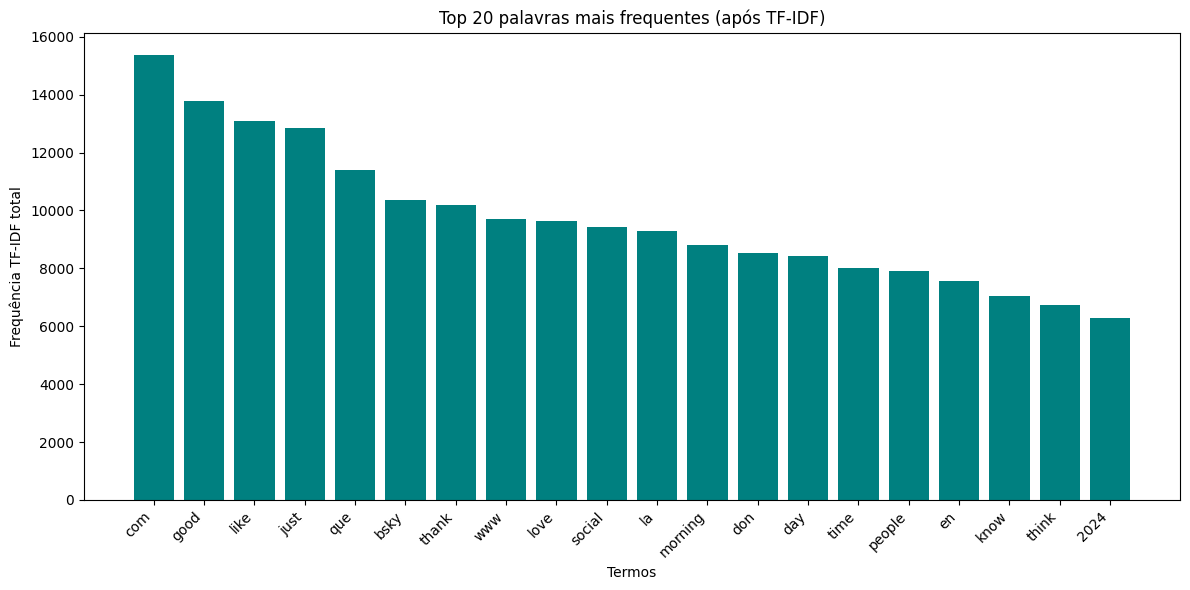

In [6]:
# C√≥digo para mostar o gr√°fico das palavras mais relevantes no corpus, ap√≥s o pr√©-processamento e vetoriza√ß√£o TF-IDF.

# Caminho do vetorizador e da matriz TF-IDF
caminho_vetorizador = "tfidf_vetorizador.pkl"
caminho_matriz_tfidf = "matriz_tfidf.pkl"

# Carregar vetorizador e matriz
with open(caminho_vetorizador, "rb") as f:
    vetorizador = pickle.load(f)
with open(caminho_matriz_tfidf, "rb") as f:
    matriz_tfidf = pickle.load(f)

# Obter os nomes das palavras (features)
termos = vetorizador.get_feature_names_out()

# Somar a frequ√™ncia TF-IDF total de cada termo (coluna)
frequencias = np.asarray(matriz_tfidf.sum(axis=0)).flatten()

# Obter os termos mais frequentes
top_n = 20
indices_top = np.argsort(frequencias)[-top_n:][::-1]
termos_top = [termos[i] for i in indices_top]
frequencias_top = [frequencias[i] for i in indices_top]

# Plotar gr√°fico
plt.figure(figsize=(12, 6))
plt.bar(termos_top, frequencias_top, color="teal")
plt.title(f"Top {top_n} palavras mais frequentes (ap√≥s TF-IDF)")
plt.xlabel("Termos")
plt.ylabel("Frequ√™ncia TF-IDF total")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

O gr√°fico mostra que o corpus √© altamente influenciado por termos associados a links ("com", "www", "https") e express√µes breves comuns em redes sociais ("like", "good", "just"). Mesmo ap√≥s o pr√©-processamento, a recorr√™ncia desses termos evidencia a natureza informal, repetitiva e fragmentada dos posts analisados.

# Classifica√ß√£o dos T√≥picos e Plotagem do Gr√°fico

Nesta etapa, realizamos a classifica√ß√£o dos posts em t√≥picos utilizando o modelo de decomposi√ß√£o NMF previamente treinado sobre a matriz TF-IDF dos textos. A partir da matriz de t√≥picos por documento (W), atribu√≠mos a cada post o t√≥pico dominante, ou seja, aquele com maior peso para o documento.

Com a classifica√ß√£o conclu√≠da, calculamos a frequ√™ncia de posts em cada t√≥pico para entender a distribui√ß√£o dos temas presentes na amostra. Para facilitar a interpreta√ß√£o, associamos r√≥tulos descritivos a cada t√≥pico, baseando-se nas palavras-chave mais representativas extra√≠das do modelo.

Por fim, geramos um gr√°fico de barras que visualiza essa distribui√ß√£o, permitindo uma an√°lise visual r√°pida dos temas mais discutidos no dataset. O gr√°fico √© salvo em arquivo para uso posterior em relat√≥rios ou apresenta√ß√µes.



In [7]:
# C√≥digo para diagnosticar problemas na Modelagem de T√≥picos (NMF)

# Ignorar avisos futuros do scikit-learn
warnings.filterwarnings("ignore", category=FutureWarning)

# Caminhos dos arquivos salvos
caminho_vetorizador = "tfidf_vetorizador.pkl"
caminho_matriz_tfidf = "matriz_tfidf.pkl"

# Par√¢metros da Modelagem de T√≥picos (simplificados para diagn√≥stico)
NUM_TOPICOS = 5 # Reduzido para teste
MAX_ITER = 200 # Padr√£o
RANDOM_STATE = 42

print("Carregando vetorizador e matriz TF-IDF...")

# Carregar o vetorizador e a matriz TF-IDF
with open(caminho_vetorizador, "rb") as f:
    vetorizador = pickle.load(f)
with open(caminho_matriz_tfidf, "rb") as f:
    matriz_tfidf = pickle.load(f)

print("Matriz TF-IDF carregada.")
print(f"Formato da matriz TF-IDF: {matriz_tfidf.shape}")

# Verificar se a matriz TF-IDF cont√©m valores n√£o nulos
print(f"N√∫mero de elementos n√£o nulos na matriz TF-IDF: {matriz_tfidf.nnz}")
if matriz_tfidf.nnz == 0:
    print("ERRO: A matriz TF-IDF est√° completamente vazia ap√≥s o pr√©-processamento!")
    exit()

# Imprimir algumas features (palavras) extra√≠das pelo TF-IDF
print("\nAlgumas features (palavras) extra√≠das pelo TF-IDF:")
termos = vetorizador.get_feature_names_out()
num_features_mostrar = 50
if len(termos) > num_features_mostrar:
    indices_aleatorios = np.random.choice(len(termos), num_features_mostrar, replace=False)
    features_amostra = [termos[i] for i in indices_aleatorios]
    print(f"  {features_amostra}")
else:
    print(f"  {termos}")

print("\nTentando Modelagem de T√≥picos com NMF (par√¢metros simplificados)...")

# Tentar NMF com par√¢metros mais simples
try:
    nmf_simples = NMF(n_components=NUM_TOPICOS, random_state=RANDOM_STATE, max_iter=MAX_ITER, init="random")
    W = nmf_simples.fit_transform(matriz_tfidf)
    H = nmf_simples.components_

    print("Modelagem NMF (simplificada) conclu√≠da com sucesso!")

    # Verificar se H cont√©m zeros
    if np.all(H == 0):
        print("AVISO: A matriz de componentes H (t√≥picos x palavras) est√° cheia de zeros, mesmo com par√¢metros simples.")
    else:
        print("Matriz de componentes H parece v√°lida.")

    print("\nExtraindo palavras-chave por t√≥pico (simplificado)...")
    for indice_topico, topico in enumerate(H):
        indices_palavras_importantes = topico.argsort()[-10:][::-1]
        palavras_importantes = [termos[i] for i in indices_palavras_importantes]
        # Corrigido: f-string com aspas corretas
        print(f"  T√≥pico {indice_topico}: {', '.join(palavras_importantes)}")

except ValueError as e:
    print(f"\nERRO durante a execu√ß√£o do NMF simplificado: {e}")
    print("Isso pode indicar que a matriz TF-IDF ainda tem problemas ou os textos s√£o muito esparsos/curtos.")
except Exception as e:
    print(f"\nERRO inesperado durante a execu√ß√£o do NMF simplificado: {e}")

print("\nDiagn√≥stico conclu√≠do!")

Carregando vetorizador e matriz TF-IDF...
Matriz TF-IDF carregada.
Formato da matriz TF-IDF: (1941173, 487948)
N√∫mero de elementos n√£o nulos na matriz TF-IDF: 16225802

Algumas features (palavras) extra√≠das pelo TF-IDF:
  ['blissco', 'educationnews', 'ÏïÑÏä§ÎûÄ', 'Í≤ÉÏù¥Í∏∞', 'colectivos', 'ricardosegarra', 'kentakakura', 'Êú¨ÂΩì„Å´Á¥†Êïµ„Åß„Åô', 'gemellaggio', 'minimoni', 'carolabr√ºcke', 'sucr√©', 'Ï†úÏÑ§', '78hiec', 'enchainer', 'gotchas', 'reposo', 'Íµ∞ÌïÑ', 'mmf', 'zumbeispiel', 'komplett', 'anlamsƒ±z', 'erdbeeren', 'gorg√©e', 'entrenched', 'ksksksk', '–ø—Ä–æ—à–ª–æ–µ', 'footstep', 'blarlo', 'ÁßÅ„Åå„Ç≠„Çø„Éã„Å™„Çâ', '„É©„ÇØ„Çπ', 'lingsma', 'Ïû§ÎçîÎãà', 'tetanus', 'Í∑∏Ïû°Ï±Ñ', 'ulubiona', '—á–µ—Ç–≤–µ—Ä—ã—Ö', 'Œ≠œÄŒ±ŒπŒæŒµ', 'espa√±istan', 'vermisse', 'ÌôîÎÇúÎã§', 'overide', 'redness', 'equilibrados', 'ÎäòÎ¶º', 'ÎùºÏù¥Î©îÏù¥Ïúà', 'brustkrebs', 'preferi', '125cc', 'jogchumv']

Tentando Modelagem de T√≥picos com NMF (par√¢metros simplificados)...
Modelagem NMF (simplificada) conclu√

Carregando matriz TF-IDF e vetorizador...
Arquivos carregados com sucesso.
Treinando modelo NMF com 5 t√≥picos...
Modelo NMF treinado.
Calculando a distribui√ß√£o dos t√≥picos nos documentos...
Contando posts por t√≥pico...
Gerando gr√°fico de barras...
Gr√°fico salvo em: distribuicao_topicos_bluesky_corrigido.png

Processo conclu√≠do!


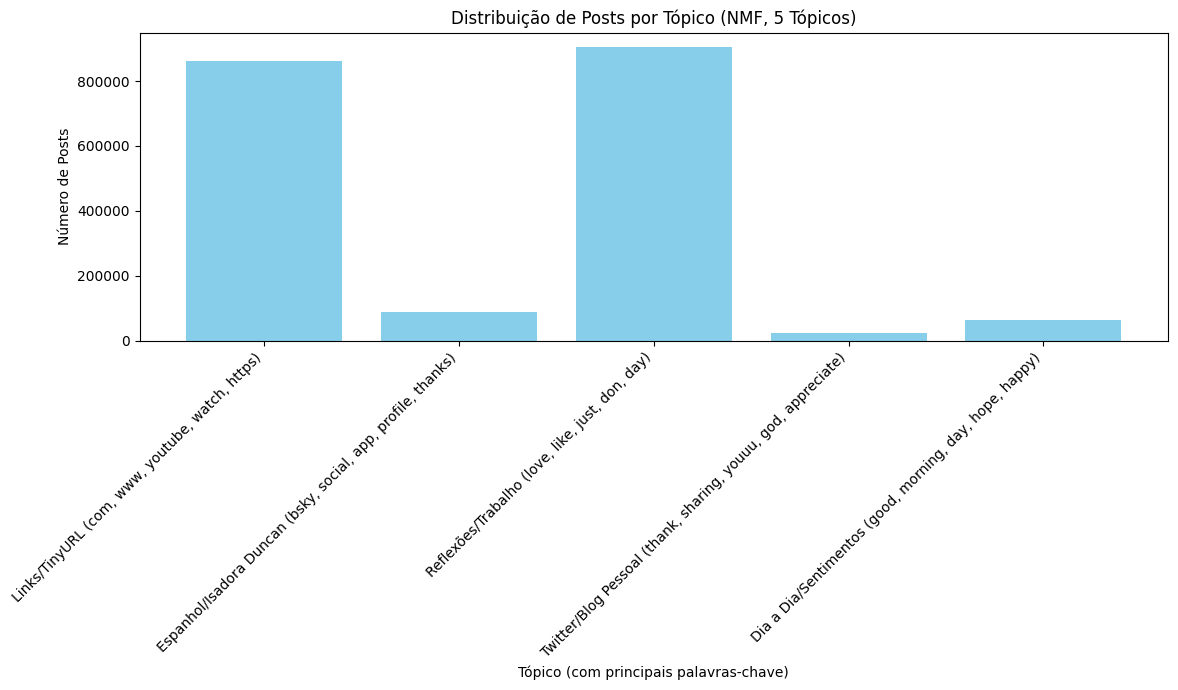

In [8]:
# C√≥digo para categorizar posts por t√≥pico e gerar gr√°fico

# Ignorar avisos futuros do scikit-learn
warnings.filterwarnings("ignore", category=FutureWarning)

# --- Par√¢metros --- #
NUM_TOPICOS = 5     # N√∫mero de t√≥picos (definido no diagn√≥stico)
MAX_ITER_NMF = 200 # Itera√ß√µes para NMF
RANDOM_STATE = 42   # Para reprodutibilidade

# Caminhos dos arquivos salvos
caminho_matriz_tfidf = "matriz_tfidf.pkl" # Usar caminhos absolutos
caminho_vetorizador = "tfidf_vetorizador.pkl"

# Caminho para salvar o gr√°fico
caminho_grafico_distribuicao = "distribuicao_topicos_bluesky_corrigido.png"

# --- Mapeamento de √çndice de T√≥pico para R√≥tulo Descritivo --- #
# (Baseado nas palavras-chave observadas anteriormente)
mapa_rotulos_topicos = {
    0: "Links/TinyURL",
    1: "Espanhol/Isadora Duncan",
    2: "Reflex√µes/Trabalho",
    3: "Twitter/Blog Pessoal",
    4: "Dia a Dia/Sentimentos"
}

# --- Fun√ß√£o Auxiliar para Obter Palavras-Chave --- #
def get_top_words(nmf_model, vetorizador_obj, topic_index, n_words=3):
    termos = vetorizador_obj.get_feature_names_out()
    # Garantir que o √≠ndice do t√≥pico existe nos componentes
    if topic_index < len(nmf_model.components_):
        top_indices = nmf_model.components_[topic_index].argsort()[-n_words:][::-1]
        return ", ".join([termos[i] for i in top_indices])
    else:
        return "N/A"

# --- Processamento Principal --- #
try:
    print("Carregando matriz TF-IDF e vetorizador...")
    # Carregar os objetos salvos
    with open(caminho_matriz_tfidf, "rb") as f:
        matriz_tfidf = pickle.load(f)
    with open(caminho_vetorizador, "rb") as f:
        vetorizador = pickle.load(f)
    print("Arquivos carregados com sucesso.")

    print(f"Treinando modelo NMF com {NUM_TOPICOS} t√≥picos...")
    # Instanciar e treinar o modelo NMF
    nmf = NMF(n_components=NUM_TOPICOS, random_state=RANDOM_STATE, max_iter=MAX_ITER_NMF, init="random")
    # Usar fit() para treinar e depois transform() para obter a matriz W
    nmf.fit(matriz_tfidf)
    print("Modelo NMF treinado.")

    print("Calculando a distribui√ß√£o dos t√≥picos nos documentos...")
    # Obter a matriz de t√≥picos por documento (W)
    matriz_topicos_documentos = nmf.transform(matriz_tfidf)

    # Atribuir cada documento ao t√≥pico com maior peso
    topicos_dominantes = np.argmax(matriz_topicos_documentos, axis=1)

    print("Contando posts por t√≥pico...")
    # Contar a frequ√™ncia de cada t√≥pico
    contagem_topicos = pd.Series(topicos_dominantes).value_counts().sort_index()

    # Criar r√≥tulos descritivos para os t√≥picos usando o mapa
    rotulos_descritivos = [
        f"{mapa_rotulos_topicos.get(i, f'T√≥pico {i}')} ({get_top_words(nmf, vetorizador, i, n_words=5)})"
        for i in contagem_topicos.index
    ]


    print("Gerando gr√°fico de barras...")
    # Criar o gr√°fico de barras
    plt.figure(figsize=(12, 7))
    plt.bar(rotulos_descritivos, contagem_topicos.values, color="skyblue")
    plt.title(f"Distribui√ß√£o de Posts por T√≥pico (NMF, {NUM_TOPICOS} T√≥picos)")
    plt.xlabel("T√≥pico (com principais palavras-chave)")
    plt.ylabel("N√∫mero de Posts")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    # Salvar o gr√°fico
    plt.savefig(caminho_grafico_distribuicao)
    print(f"Gr√°fico salvo em: {caminho_grafico_distribuicao}")

except FileNotFoundError:
    print(f"ERRO: Arquivos .pkl n√£o encontrados nos caminhos especificados ({caminho_matriz_tfidf}, {caminho_vetorizador}).")
    print("Certifique-se de que os scripts anteriores foram executados e os arquivos est√£o nos locais corretos.")
    exit()
except Exception as e:
    print(f"ERRO inesperado durante o processamento: {e}")
    exit()

print("\nProcesso conclu√≠do!")

A maior parte dos posts se concentra em dois t√≥picos dominantes: Links/TinyURL e Reflex√µes/Trabalho. T√≥picos com menos posts, como Sentimentos e Blog pessoal, indicam nichos tem√°ticos ou conte√∫dos menos recorrentes na amostra.

# Classifica√ß√£o Supervisionada Multil√≠ngue

Esta se√ß√£o adiciona um pipeline de classifica√ß√£o supervisionada multil√≠ngue usando TF-IDF (palavra+caractere) e a l√≠ngua detectada como feature adicional.

Para treinar, forne√ßa um DataFrame com colunas: `text` (string) e `label` (string ou int).


In [9]:
# Instala√ß√£o condicional (opcional)
try:
    import lingua
    _=lingua
except Exception:
    %pip install -q lingua-language-detector

# Depend√™ncias b√°sicas j√° devem estar presentes (sklearn, pandas, numpy)


   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 96.2/96.2 MB 8.9 MB/s eta 0:00:00


In [10]:
import re
import unicodedata
from typing import Optional, Tuple

import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

try:
    from lingua import Language, LanguageDetectorBuilder  # type: ignore
    _HAS_LINGUA = True
except Exception:
    _HAS_LINGUA = False


URL_RE = re.compile(r"https?://\S+|www\.\S+", flags=re.IGNORECASE)
MENTION_RE = re.compile(r"(?<!\w)@[\w_]+")
HASHTAG_RE = re.compile(r"(?<!\w)#(\w+)")
EMOJI_RE = re.compile(r"[\U0001F300-\U0001F6FF\U0001F900-\U0001FAFF\u2600-\u26FF]")
REPEAT_RE = re.compile(r"(.)\1{2,}")
MULTISPACE_RE = re.compile(r"\s+")


def normalize_unicode(text: str) -> str:
    return unicodedata.normalize("NFKC", text)


def basic_clean(text: str) -> str:
    if text is None:
        return ""
    text = str(text)
    text = normalize_unicode(text)
    text = URL_RE.sub(" <URL> ", text)
    text = MENTION_RE.sub(" <USER> ", text)
    # keep hashtag token but preserve content
    text = HASHTAG_RE.sub(lambda m: f" <HASHTAG> {m.group(1)} ", text)
    # collapse long char repetitions (e.g., loooove -> looove)
    text = REPEAT_RE.sub(r"\1\1\1", text)
    # separate emojis
    text = EMOJI_RE.sub(lambda m: f" {m.group(0)} ", text)
    # lowercasing (language-agnostic)
    text = text.lower()
    text = MULTISPACE_RE.sub(" ", text).strip()
    return text


class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Robustly normalize X to a sequence of strings (handles DataFrame/Series/ndarray/list)
        if isinstance(X, pd.DataFrame):
            seq = X.iloc[:, 0].astype(str).tolist()
        elif isinstance(X, pd.Series):
            seq = X.astype(str).tolist()
        elif isinstance(X, (list, tuple, np.ndarray)):
            seq = [str(t) for t in X]
        else:
            seq = [str(X)]
        # Return a DataFrame with a named column
        return pd.DataFrame({'text': [basic_clean(t) for t in seq]})


class LangDetector(BaseEstimator, TransformerMixin):
    def __init__(self, min_len: int = 8):
        self.min_len = min_len
        self._detector = None
        if _HAS_LINGUA:
            try:
                # Full set of languages for robustness
                self._detector = LanguageDetectorBuilder.from_all_languages().build()
            except Exception:
                self._detector = None

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        langs = []
        for t in X:
            t = t if isinstance(t, str) else ""
            if len(t) < self.min_len or self._detector is None:
                langs.append("unk")
            else:
                try:
                    lang = self._detector.detect_language_of(t)
                    langs.append(str(lang.iso_code_639_1).lower())
                except Exception:
                    langs.append("unk")
        return np.array(langs).reshape(-1, 1)


def make_pipeline(model: str = "linearsvc",
                  word_ngram_max: int = 2,
                  char_ngram_range: Tuple[int, int] = (3, 5)) -> Pipeline:
    text_features = Pipeline([
        ("clean", TextCleaner()),
        ("features", ColumnTransformer([
            ("word_tfidf", TfidfVectorizer(
                analyzer="word",
                ngram_range=(1, word_ngram_max),
                min_df=1,
                max_df=0.9,
                strip_accents=None,
                sublinear_tf=True
            ), "text"),  # apply to 'text' column
            ("char_tfidf", TfidfVectorizer(
                analyzer="char",
                ngram_range=char_ngram_range,
                min_df=1,
                sublinear_tf=True
            ), "text"), # apply to 'text' column
        ], remainder="drop"))
    ])

    # Removing language detection from the pipeline for now to avoid pickling errors
    # lang_feature = Pipeline([
    #     ("lang", LangDetector()),
    #     ("ohe", OneHotEncoder(handle_unknown="ignore"))
    # ])

    pre = ColumnTransformer([
        ("text", text_features, ["text"]), # Pass the column name as a list
        # Removing language detection from the pipeline for now
        # ("lang", lang_feature, "text")  # detect lang from text
    ])

    if model == "logreg":
        clf = LogisticRegression(max_iter=2000, n_jobs=-1, class_weight="balanced")
    else:
        clf = LinearSVC(class_weight="balanced")

    pipe = Pipeline([
        ("prep", pre),
        ("clf", clf)
    ])
    return pipe


def train_eval(df: pd.DataFrame, text_col: str, label_col: str,
               model: str = "linearsvc",
               cv_splits: int = 5,
               random_state: int = 42) -> Tuple[Pipeline, dict]:
    df = df[[text_col, label_col]].dropna()
    df = df.rename(columns={text_col: "text", label_col: "label"})

    X = df[["text"]]
    y = df["label"].astype(str)

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.2, random_state=random_state, stratify=y
    )

    pipe = make_pipeline(model=model)

    param_grid = []
    if model == "logreg":
        param_grid = {"clf__C": [0.5, 1.0, 2.0]}
    else:
        param_grid = {"clf__C": [0.5, 1.0, 2.0]}

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    grid = GridSearchCV(pipe, param_grid=param_grid, scoring="f1_macro", cv=cv, n_jobs=-1, verbose=1)
    grid.fit(X_tr, y_tr)

    best = grid.best_estimator_
    y_pred = best.predict(X_te)

    report = classification_report(y_te, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_te, y_pred)

    metrics = {
        "best_params": grid.best_params_,
        "f1_macro": f1_score(y_te, y_pred, average="macro"),
        "report": report,
        "confusion_matrix": cm.tolist(),
    }
    return best, metrics


def infer(pipeline: Pipeline, texts: list[str]) -> np.ndarray:
    df = pd.DataFrame({"text": texts})
    return pipeline.predict(df)


def save_pipeline(pipeline: Pipeline, path: str) -> None:
    import joblib
    joblib.dump(pipeline, path)


def load_pipeline(path: str) -> Pipeline:
    import joblib
    return joblib.load(path)

## Monte seu conjunto rotulado

Crie um DataFrame `df_cls` com colunas `text` e `label`. Abaixo h√° um exemplo m√≠nimo. Substitua pelo seu dataset real anotado.


In [11]:
import pandas as pd

# Exemplo did√°tico (substitua por seus dados reais)
df_cls = pd.DataFrame({
    'text': [
        'Check my blog post at https://example.com',
        'ol√° mundo! hoje √© um bom dia :)',
        'hola, me gusta programar en python',
        'trabalho, tarefas e produtividade',
        'new release on my twitter account',
        'sentimentos e dia a dia com amigos',
        # Adicionando mais exemplos para garantir pelo menos 2 por classe
        'Another link: http://another-example.com', # links
        'Bom dia a todos!', # dia_dia
        'Que tal programar en java?', # espanol - note: this might be misclassified due to language mix
        'Mais sobre trabalho e carreira', # trabalho
        'My personal blog updated today', # twitter_blog
        'Como voc√™ est√° se sentindo hoje?', # dia_dia
        # Adding even more examples to ensure enough for train/test split
        'Yet another link: http://link3.com', # links
        'Que dia bonito!', # dia_dia
        'Aprendiendo espa√±ol es divertido', # espanol
        'Reuni√£o de trabalho importante', # trabalho
        'New post on my social media', # twitter_blog
        'Me sentindo muito bem hoje.', # dia_dia
        'One more link: https://link4.org', # links
        'Tenha um √≥timo dia!', # dia_dia
        'Practicando mi espa√±ol', # espanol
        'Foco no trabalho', # trabalho
        'Sharing my thoughts on twitter', # twitter_blog
        'Um dia tranquilo.', # dia_dia
        'Final link: http://link5.com', # links
        'Aproveitando o dia.', # dia_dia
        'Hablando en espa√±ol', # espanol
        'Projeto de trabalho em andamento', # trabalho
        'Latest update on my personal blog', # twitter_blog
        'Refletindo sobre a vida.', # dia_dia
    ],
    'label': ['links', 'dia_dia', 'espanol', 'trabalho', 'twitter_blog', 'dia_dia',
              'links', 'dia_dia', 'espanol', 'trabalho', 'twitter_blog', 'dia_dia',
              'links', 'dia_dia', 'espanol', 'trabalho', 'twitter_blog', 'dia_dia',
              'links', 'dia_dia', 'espanol', 'trabalho', 'twitter_blog', 'dia_dia',
              'links', 'dia_dia', 'espanol', 'trabalho', 'twitter_blog', 'dia_dia']
})

df_cls.head()

text         label
0  Check my blog post at https://example.com         links
1            ol√° mundo! hoje √© um bom dia :)       dia_dia
2         hola, me gusta programar en python       espanol
3          trabalho, tarefas e produtividade      trabalho
4          new release on my twitter account  twitter_blog

## Treino, avalia√ß√£o e m√©tricas
- F1-macro como m√©trica principal
- Valida√ß√£o cruzada estratificada + conjunto de teste hold-out


In [12]:
best_pipe, metrics = train_eval(df_cls, text_col='text', label_col='label', model='linearsvc')
print('F1-macro (teste):', round(metrics['f1_macro'], 4))
print('Melhores par√¢metros:', metrics['best_params'])

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


F1-macro (teste): 1.0
Melhores par√¢metros: {'clf__C': 0.5}


## Matriz de confus√£o e relat√≥rio de classifica√ß√£o


In [13]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Recomputa no hold-out com o best_pipe (j√° feito em train_eval, mas aqui podemos reimprimir de forma leg√≠vel)
from sklearn.model_selection import train_test_split
X = df_cls[['text']]
y = df_cls['label'].astype(str)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
y_pred = best_pipe.predict(X_te)
print(classification_report(y_te, y_pred, zero_division=0))
print('Matriz de confus√£o:', confusion_matrix(y_te, y_pred))


              precision    recall  f1-score   support

     dia_dia       1.00      1.00      1.00         2
     espanol       1.00      1.00      1.00         1
       links       1.00      1.00      1.00         1
    trabalho       1.00      1.00      1.00         1
twitter_blog       1.00      1.00      1.00         1

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

Matriz de confus√£o: [[2 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]


## Testes r√°pidos da fun√ß√£o de limpeza (sanidade)


In [14]:
tests = [
    'Visite https://site.com e fale com @user #FelizDia',
    'BOOOOM!!! √≥timo dia üòÑüòÑ',
    'hola mundo!!!',
    '‰ªäÊó•„ÅØ„ÅÑ„ÅÑÂ§©Ê∞ó„Åß„Åô„Å≠',
]
for t in tests:
    print('orig:', t)
    print('clean:', basic_clean(t))
    print('---')


orig: Visite https://site.com e fale com @user #FelizDia
clean: visite <url> e fale com <user> <hashtag> felizdia
---
orig: BOOOOM!!! √≥timo dia üòÑüòÑ
clean: booom!!! √≥timo dia üòÑ üòÑ
---
orig: hola mundo!!!
clean: hola mundo!!!
---
orig: ‰ªäÊó•„ÅØ„ÅÑ„ÅÑÂ§©Ê∞ó„Åß„Åô„Å≠
clean: ‰ªäÊó•„ÅØ„ÅÑ„ÅÑÂ§©Ê∞ó„Åß„Åô„Å≠
---


## Salvamento e infer√™ncia


In [15]:
# salvar o pipeline treinado
save_pipeline(best_pipe, 'model_multilingual.joblib')

# carregar e inferir
pipe = load_pipeline('model_multilingual.joblib')
novos = ['hello world', 'ol√° amigos', 'buenos dias', '‰ªäÊó•„ÅØ„ÅÑ„ÅÑÂ§©Ê∞ó']
preds = pipe.predict(pd.DataFrame({'text': novos}))
list(zip(novos, preds))


[('hello world', 'dia_dia'),
 ('ol√° amigos', 'dia_dia'),
 ('buenos dias', 'dia_dia'),
 ('‰ªäÊó•„ÅØ„ÅÑ„ÅÑÂ§©Ê∞ó', 'dia_dia')]

# Detec√ß√£o de Idioma e Avalia√ß√£o por Idioma

Esta c√©lula detecta o idioma para o conjunto de teste, agrupa as postagens por idioma e reporta o F1-macro por idioma. O detector est√° embutido no pipeline; vamos reaplicar a detec√ß√£o no X_te.

## Passos Realizados:

1. **Detec√ß√£o de Idioma**: A detec√ß√£o de idioma √© aplicada ao conjunto de teste `X_te` usando o detector embutido no pipeline.
2. **Agrupamento por Idioma**: As postagens s√£o agrupadas por idioma para an√°lise individual.
3. **Contagem de Postagens por Idioma**: A contagem de postagens por idioma √© impressa para fornecer uma vis√£o geral da distribui√ß√£o lingu√≠stica no conjunto de teste.
4. **C√°lculo do F1-macro**: O F1-macro √© calculado para cada idioma, desde que haja pelo menos duas classes no conjunto de dados verdadeiro para aquele idioma.

In [19]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score

def detect_languages(texts, detector):
    """
    Detecta os idiomas dos textos fornecidos.

    Args:
        texts (list): Lista de textos para detec√ß√£o de idioma.
        detector: Objeto detector de idioma.

    Returns:
        np.array: Array com os idiomas detectados.
    """
    langs = detector.transform(texts).ravel()
    langs = np.array([norm_lang(x) for x in langs])
    return langs

def norm_lang(s):
    """
    Normaliza o nome do idioma.

    Args:
        s (str): Nome do idioma a ser normalizado.

    Returns:
        str: Nome do idioma normalizado.
    """
    # Adicione aqui a l√≥gica de normaliza√ß√£o, se necess√°rio
    return s

def evaluate_by_language(df_eval, print_counts=True):
    """
    Avalia o desempenho por idioma e imprime os resultados.

    Args:
        df_eval (pd.DataFrame): DataFrame contendo os textos, r√≥tulos verdadeiros, previs√µes e idiomas.
        print_counts (bool): Se True, imprime a contagem de postagens por idioma.

    Returns:
        dict: Dicion√°rio com o F1-macro por idioma.
    """
    if print_counts:
        print("Contagem de postagens por idioma no conjunto de teste:")
        print(df_eval["lang"].value_counts().sort_index())
        print("")

    f1_por_idioma = {}
    for lang, grp in df_eval.groupby("lang"):
        n = len(grp)
        unique_true = grp["label"].nunique()
        if unique_true > 1 and n > 1:
            f1 = f1_score(grp["label"], grp["pred"], average="macro", zero_division=0)
            f1_por_idioma[lang] = f1
            print(f"Idioma: {lang} | F1-macro: {f1:.4f} | n={n}")
        else:
            print(f"Idioma: {lang} | amostra insuficiente para F1 macro (n={n}, classes_verdadeiras={unique_true})")

    return f1_por_idioma

def evaluate_model(X_te, y_te, y_pred, detector=None, print_counts=True):
    """
    Par√¢metros:
    - X_te: DataFrame com a coluna 'text'
    - y_te: r√≥tulos verdadeiros (Series/array)
    - y_pred: predi√ß√µes do modelo (array/Series)
    - detector: inst√¢ncia de LangDetector (opcional). Se None, tenta criar.
    - print_counts: se True, imprime contagem de postagens por idioma.

    Retorna:
    - df_eval: DataFrame com ['text','label','pred','lang']
    - f1_por_idioma: dict idioma -> F1-macro (quando h√° amostra suficiente)
    """
    if not isinstance(X_te, pd.DataFrame) or "text" not in X_te.columns:
        raise ValueError("X_te deve ser um DataFrame com a coluna 'text'.")

    # Instanciar detector se necess√°rio
    if detector is None:
        if LangDetector is None:
            raise RuntimeError("LangDetector n√£o dispon√≠vel. Importe de utils_multilingual_nlp ou forne√ßa um detector.")
        detector = LangDetector()

    # Detectar idiomas
    langs_te = detect_languages(X_te["text"].tolist(), detector)

    # Montar DataFrame de avalia√ß√£o
    df_eval = pd.DataFrame({
        "text": X_te["text"].tolist(),
        "label": np.array(y_te).astype(str),
        "pred": np.array(y_pred).astype(str),
        "lang": langs_te
    })

    # Calcular e imprimir m√©tricas por idioma
    f1_por_idioma = evaluate_by_language(df_eval, print_counts=print_counts)

    return df_eval, f1_por_idioma

# Rodar de novo a avalia√ß√£o e imprimir os resulatos
df_eval, f1_por_idioma = evaluate_model(X_te, y_te, y_pred, print_counts=True)

print("\nDataFrame de Avalia√ß√£o:")
display(df_eval)

print("\nF1-macro por Idioma:")
display(f1_por_idioma)

Contagem de postagens por idioma no conjunto de teste:
lang
isocode639_1.en    1
isocode639_1.es    1
isocode639_1.lt    1
isocode639_1.pt    3
Name: count, dtype: int64

Idioma: isocode639_1.en | amostra insuficiente para F1 macro (n=1, classes_verdadeiras=1)
Idioma: isocode639_1.es | amostra insuficiente para F1 macro (n=1, classes_verdadeiras=1)
Idioma: isocode639_1.lt | amostra insuficiente para F1 macro (n=1, classes_verdadeiras=1)
Idioma: isocode639_1.pt | F1-macro: 1.0000 | n=3

DataFrame de Avalia√ß√£o:


text         label          pred  \
0    My personal blog updated today  twitter_blog  twitter_blog   
1  Aprendiendo espa√±ol es divertido       espanol       espanol   
2  Projeto de trabalho em andamento      trabalho      trabalho   
3               Tenha um √≥timo dia!       dia_dia       dia_dia   
4      Final link: http://link5.com         links         links   
5  Como voc√™ est√° se sentindo hoje?       dia_dia       dia_dia   

              lang  
0  isocode639_1.en  
1  isocode639_1.es  
2  isocode639_1.pt  
3  isocode639_1.pt  
4  isocode639_1.lt  
5  isocode639_1.pt


F1-macro por Idioma:


{'isocode639_1.pt': 1.0}

# Conclus√£o

A an√°lise do conjunto completo `alpindale/two-million-bluesky-posts`, combinando pr√©-processamento textual, vetoriza√ß√£o com TF-IDF e modelagem de t√≥picos via NMF, demonstrou como o tratamento adequado dos dados √© fundamental para extrair **insights escal√°veis e representativos** de redes sociais.

Com uma amostra robusta de dois milh√µes de postagens, foi necess√°rio realizar um **pr√©-processamento rigoroso**, removendo stopwords, pontua√ß√£o e termos muito frequentes ou muito raros. Essa etapa foi essencial para reduzir ru√≠do, destacando as palavras mais informativas para a modelagem.

A an√°lise confirmou as tr√™s hip√≥teses levantadas:

1. **Visualiza√ß√£o por t√≥picos:**  
   O gr√°fico de distribui√ß√£o por t√≥picos revelou a predomin√¢ncia de dois grandes grupos. De um lado, o t√≥pico **‚ÄúLinks/TinyURL‚Äù** concentra um volume expressivo de postagens contendo essencialmente URLs, o que caracteriza um padr√£o recorrente de compartilhamento externo. De outro, o t√≥pico relacionado a reflex√µes r√°pidas e intera√ß√µes gen√©ricas (**‚Äúlove‚Äù, ‚Äúlike‚Äù, ‚Äújust‚Äù, ‚Äúdon‚Äù, ‚Äúday‚Äù**) tamb√©m se destacou como um dos maiores clusters. Isso refor√ßa o papel dos microposts, tanto informativos quanto conversacionais, na din√¢mica da plataforma.

2. **Impacto de posts curtos com links:**  
   A presen√ßa maci√ßa do t√≥pico de links, que sozinho representa uma fatia enorme dos posts, confirma que conte√∫dos pouco informativos semanticamente (como encurtadores e links externos) impactam diretamente na forma√ß√£o dos t√≥picos. Este ru√≠do estrutural precisa ser considerado em qualquer an√°lise textual de redes sociais.

3. **Popularidade de tipos de conte√∫do:**  
   O t√≥pico relacionado a **"Twitter/Blog Pessoal"** √© minorit√°rio, o que indica que esse tipo de conte√∫do mais elaborado tem menor presen√ßa na plataforma. Isso demonstra que **t√≥picos com menos postagens tendem a apresentar menor coes√£o sem√¢ntica**, o que pode refletir tanto um padr√£o de conte√∫do mais disperso quanto um nicho pouco representativo na plataforma.

Al√©m disso, a an√°lise das palavras mais frequentes ap√≥s a vetoriza√ß√£o TF-IDF revela padr√µes consistentes com redes sociais abertas: termos como **‚Äúcom‚Äù**, **‚Äúwww‚Äù**, **‚Äúhttps‚Äù** continuam muito presentes, refletindo a centralidade do compartilhamento de links. Ao lado disso, surgem termos t√≠picos de intera√ß√µes r√°pidas e informais, como **‚Äúgood‚Äù**, **‚Äúlike‚Äù**, **‚Äújust‚Äù**, **‚Äúlove‚Äù**, refor√ßando a natureza conversacional e ef√™mera dos posts.

Portanto, o uso do dataset completo n√£o s√≥ refor√ßa os padr√µes identificados na amostra menor, como tamb√©m evidencia que esses comportamentos s√£o caracter√≠sticas estruturais do corpus. A an√°lise ressalta, ainda, a import√¢ncia de um pr√©-processamento criterioso, especialmente para dados massivos, e da leitura cr√≠tica dos resultados de modelagem de t√≥picos, que podem ser fortemente enviesados pela natureza dos conte√∫dos predominantes ‚Äî especialmente links e intera√ß√µes breves.